In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import alen, arange
import math
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

from sklearn.svm import SVR
#### PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter

In [16]:
#BPSO

def pls_optimise_components(X, y, npc):
 
    rmsecv = np.zeros(npc)
    for i in range(1,npc+1,1):
 
        # Simple PLS
        pls_simple = PLSRegression(n_components=i)
        # Fit
        pls_simple.fit(X, y)
        #cv = LeaveOneOut()
        cv=10
        # Cross-validation
        y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
        # Calculate scores
        score = r2_score(y, y_cv)
        rmsecv[i-1] = np.sqrt(mean_squared_error(y, y_cv))
 
    # Find the minimum of ther RMSE and its location
    opt_comp, rmsecv_min = np.argmin(rmsecv),  rmsecv[np.argmin(rmsecv)]
 
    return (opt_comp+1, rmsecv_min)

def base_pls(X,y,n_components, return_model=False):
 
    # Simple PLS
    pls_simple = PLSRegression(n_components=n_components)
    # Fit
    pls_simple.fit(X, y)
    #cv = 10
    cv= 10
    # Cross-validation
    y_cv = cross_val_predict(pls_simple, X, y, cv=cv)
 
    # Calculate scores
    score = r2_score(y, y_cv)
    rmsecv = np.sqrt(mean_squared_error(y, y_cv))
 
    if return_model == False:
        return(y_cv, score, rmsecv)
    else:
        return(y_cv, score, rmsecv, pls_simple)
    
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Create an instance 
#reg = linear_model.LinearRegression

# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    
    total_features = dimensions
    # Get the subset of the features from the binary mask

    #X_sav = savgol_filter(X_train, 3, polyorder=2, deriv=1)

    if np.count_nonzero(m) == 0:
        X_subset = X_train
    else:
        X_subset = X_train[:,m==1]

    
 

    # #regr = make_pipeline(StandardScaler(), SVR())
    # #regr = make_pipeline(StandardScaler(), RandomForestRegressor(max_depth=5, random_state=1))
    # #regr = make_pipeline(StandardScaler(), SVR(C = 0.5, degree= 1, kernel= 'rbf',epsilon= 0.16))
    # #X1 = savgol_filter(X_subset, 3, polyorder=2, deriv=1)
    # reg1 = GradientBoostingRegressor(random_state=1)
    # reg2 = RandomForestRegressor(random_state=1)
    # reg3 = LinearRegression()
    # ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
    # ereg = ereg.fit(X_subset, y_train_oleo)
    # #regr.fit(X_subset, y_train_oleo)
    # #y_pred = cross_val_predict(regr, X_subset, y_train_oleo, cv=10)
    # y_pred = ereg.predict(X_subset)
    # #y_pred = regr.predict(X1)
    # r2cv = mean_squared_error(y_train_oleo, y_pred)
    # #r2cv = r2_score(y_train_oleo, y_pred)
    # P = r2cv
    # #P = (classifier.predict(X_subset) == y).mean()
    # # Compute for the objective function
    # j = (alpha * (1.0 - (1-P))
    #     + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))



    opt_comp, rmsecv_min = pls_optimise_components(X_subset, y_train_oleo, 6)
    predicted, r2cv, rmscv = base_pls(X_subset, y_train_oleo, opt_comp)
    
    P = r2cv
    #P = (classifier.predict(X_subset) == y).mean()
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))

    return j

def f(x, alpha=0.88):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    output_data = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
 
        # Apply correction
        output_data[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
 
    return output_data

def msc(input_data):
     # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
 
    # Get the reference spectrum. If not given, estimate it from the mean    

    # Calculate mean
    ref = np.mean(input_data, axis=0)

 
    # Define a new array and populate it with the corrected data    
    output_data= np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        output_data[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return output_data

In [17]:
df = pd.read_excel('Data/Cacao/NIRS spectrum Cocoa Beans.xlsx', skiprows=[0,1,2,3,4,5])

In [18]:
df.head()

,sample Num,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,...,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Moisture Content (%),Fat Content (%)
0,1,0.455245,0.455134,0.454986,0.455009,0.454722,0.454652,0.454516,0.454527,0.454581,...,1.240786,1.244121,1.246720,1.249081,1.250945,1.252397,1.253387,1.254267,8.17,39.11000
1,2,0.485282,0.485407,0.485407,0.485478,0.485399,0.485284,0.485150,0.485174,0.485439,...,1.263340,1.266759,1.269205,1.271461,1.273356,1.274930,1.276129,1.277142,7.52,39.14000
2,3,0.504128,0.503784,0.503550,0.503983,0.503992,0.503576,0.503656,0.503647,0.503327,...,1.298061,1.301578,1.304317,1.306653,1.308487,1.310115,1.310987,1.311702,8.52,42.35439
3,4,0.470077,0.469761,0.469780,0.469852,0.469783,0.469600,0.469520,0.469439,0.469648,...,1.240584,1.243668,1.246182,1.248631,1.250560,1.252181,1.253309,1.254296,8.65,42.71632
4,5,0.495356,0.495335,0.495513,0.495504,0.495303,0.495128,0.495118,0.495339,0.495136,...,1.300846,1.304284,1.306948,1.309266,1.311007,1.312586,1.313464,1.314298,7.66,38.57000


In [19]:
df.describe()

,sample Num,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,...,2483.5,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Moisture Content (%),Fat Content (%)
count,72.00000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,...,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,36.50000,0.553672,0.553252,0.553195,0.553385,0.553181,0.552734,0.552676,0.552743,0.552677,...,1.355246,1.358534,1.361217,1.363559,1.365416,1.367055,1.368250,1.369333,9.036111,40.319422
std,20.92845,0.058118,0.058024,0.058001,0.057977,0.057892,0.057755,0.057687,0.057656,0.057599,...,0.077153,0.077181,0.077192,0.077227,0.077250,0.077317,0.077330,0.077353,1.276969,2.153408
min,1.00000,0.453846,0.453121,0.453382,0.453692,0.453737,0.453246,0.453506,0.453738,0.453617,...,1.169063,1.172108,1.174711,1.176826,1.178704,1.180210,1.181361,1.182412,6.740000,35.259180
25%,18.75000,0.506507,0.506184,0.505822,0.506032,0.506154,0.505824,0.505751,0.505866,0.505862,...,1.302396,1.305891,1.308618,1.311181,1.313362,1.315192,1.316658,1.318237,8.087500,38.551392
50%,36.50000,0.539088,0.538746,0.538902,0.539029,0.538547,0.538157,0.538385,0.538500,0.538432,...,1.358992,1.362210,1.364917,1.367153,1.368977,1.370487,1.371482,1.372305,8.785000,40.126075
75%,54.25000,0.590582,0.589999,0.590054,0.590657,0.590543,0.590027,0.590106,0.590380,0.590249,...,1.411312,1.414535,1.417293,1.419362,1.421241,1.423092,1.424101,1.424838,9.562500,41.927608
max,72.00000,0.726047,0.725450,0.725075,0.725353,0.725137,0.724066,0.723827,0.723877,0.723535,...,1.495987,1.499257,1.501925,1.504354,1.505840,1.507209,1.508215,1.509087,12.080000,45.745860


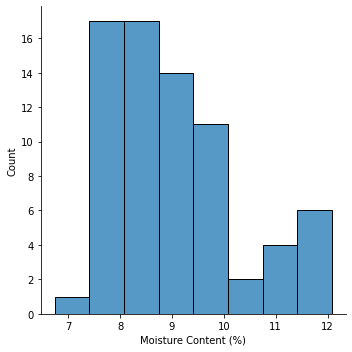

In [20]:
import seaborn as sns
sns.displot(df['Moisture Content (%)'])

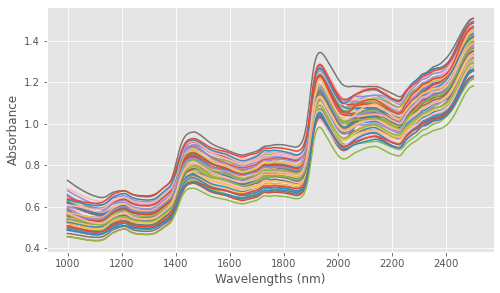

In [21]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(df.iloc[:,1:-2].columns.astype('float'), df.iloc[:,1:-2].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

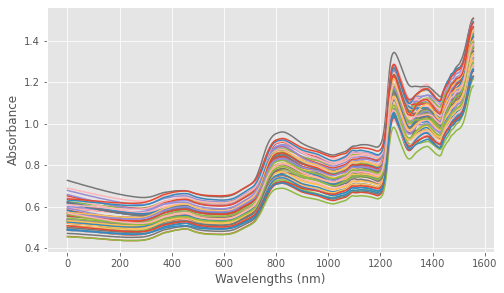

In [22]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df.iloc[:,1:-2].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

In [23]:
df.iloc[:,1:-2] = savgol_filter(df.values[:,1:-2], 3, polyorder=2, deriv=1)
df_pretreat = df.iloc[:, 1:-2]
df_pretreat['Umidade'] = df['Moisture Content (%)']
df_pretreat['Oleo'] = df['Fat Content (%)']
df_pretreat['class'] = df_pretreat['Umidade'].astype(int)

for index, row in df_pretreat.iterrows():
    if row['class']== 12 or row['class']== 6:
        df_pretreat.loc[index, 'class'] = 12

df_pretreat

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Umidade,Oleo,class
0,-0.000092,-0.000129,-0.000063,-0.000132,-0.000179,-0.000103,-0.000062,0.000032,-0.000203,-0.000159,...,0.002967,0.002480,0.002112,0.001658,0.001221,0.000935,0.000825,8.17,39.11000,8
1,0.000188,0.000063,0.000036,-0.000004,-0.000097,-0.000124,-0.000055,0.000144,-0.000074,-0.000382,...,0.002932,0.002351,0.002075,0.001734,0.001387,0.001106,0.000920,7.52,39.14000,7
2,-0.000398,-0.000289,0.000099,0.000221,-0.000203,-0.000168,0.000035,-0.000165,-0.000240,-0.000131,...,0.003128,0.002538,0.002085,0.001731,0.001250,0.000793,0.000637,8.52,42.35439,8
3,-0.000483,-0.000148,0.000045,0.000001,-0.000126,-0.000132,-0.000081,0.000064,-0.000034,-0.000317,...,0.002799,0.002481,0.002189,0.001775,0.001374,0.001057,0.000917,8.65,42.71632,8
4,-0.000121,0.000078,0.000084,-0.000105,-0.000188,-0.000092,0.000106,0.000009,-0.000228,-0.000167,...,0.003051,0.002491,0.002029,0.001660,0.001228,0.000856,0.000812,7.66,38.57000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.000411,-0.000133,0.000020,-0.000149,-0.000182,-0.000023,-0.000075,-0.000104,-0.000207,-0.000169,...,0.003082,0.002374,0.002103,0.001799,0.001416,0.001159,0.000920,9.29,36.49000,9
68,-0.001219,-0.000408,0.000103,-0.000071,-0.000409,-0.000395,-0.000037,0.000170,-0.000288,-0.000543,...,0.002933,0.002474,0.002148,0.001810,0.001491,0.001279,0.001157,8.02,41.30000,8
69,-0.001329,-0.000663,-0.000093,0.000072,-0.000159,-0.000382,-0.000169,0.000043,-0.000354,-0.000461,...,0.002772,0.002314,0.002154,0.001884,0.001442,0.001155,0.001175,7.70,38.89000,7
70,-0.000537,-0.000066,0.000156,-0.000002,-0.000252,-0.000370,-0.000132,0.000070,-0.000272,-0.000370,...,0.002639,0.002218,0.001832,0.001564,0.001133,0.000762,0.000700,7.77,39.37000,7


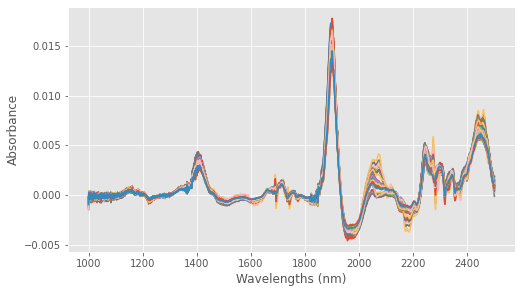

In [24]:
wl = np.arange(0, 1557, 1)
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(df.iloc[:,1:-2].columns.astype('float'), df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

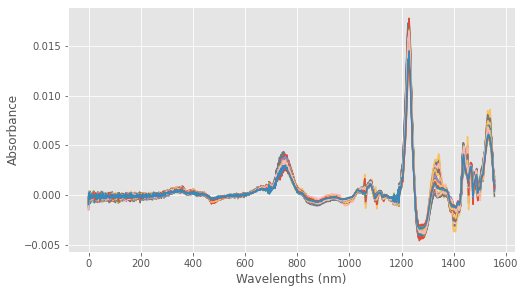

In [25]:

plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(wl, df_pretreat.iloc[:,:-3].values.T)
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("Absorbance")
    plt.show()

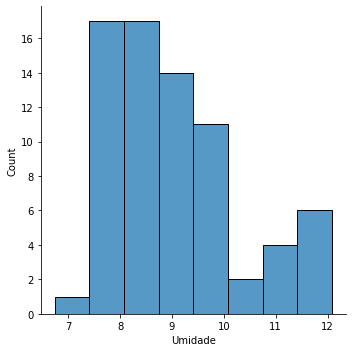

In [26]:
import seaborn as sns
sns.displot(df_pretreat['Umidade'])

In [27]:
df_pretreat[df_pretreat['class']==12]

,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003,1003.4,...,2485.8,2488.2,2490.6,2493,2495.4,2497.8,2500.2,Umidade,Oleo,class
10,-0.000283,-0.000596,-0.000302,0.000143,-0.000075,0.000024,0.000271,-0.000083,-0.000378,-0.000140,...,0.003195,0.002645,0.001843,0.001287,0.000883,0.000382,-0.000106,6.74,38.37085,12
37,-0.001071,-0.000632,-0.000094,-0.000149,-0.000520,-0.000399,-0.000173,-0.000396,-0.000746,-0.000512,...,0.003305,0.002920,0.002281,0.001970,0.001904,0.001725,0.001561,12.08,41.75199,12


In [28]:
df_pretreat['class'].nunique()

6

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



pca = PCA(n_components=5)
T = pca.fit_transform(df_pretreat.iloc[:,:-3])
df_pca = pd.DataFrame(T)
df_pca.rename(columns={0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4', 4: 'PC5'}, inplace=True)

print(pca.explained_variance_ratio_)


[0.52831014 0.23143533 0.09730903 0.04082419 0.01670712]


In [170]:
#df_pca['PC1'] = df_pca['PC1']*-1
df_pca['PC2'] = df_pca['PC2']*-1
df_pca['ID'] = df['sample Num']
df_pca

,PC1,PC2,PC3,PC4,PC5,ID
0,-3.862202,0.177252,0.113721,-0.030735,0.008251,1
1,-2.829240,-0.060656,-0.047625,-0.038181,-0.033535,2
2,-1.806598,0.032977,-0.147242,-0.050365,-0.008792,3
3,-3.532588,-0.075883,0.006264,-0.058364,-0.034904,4
4,-1.866254,0.163004,-0.094362,-0.071712,0.038916,5
...,...,...,...,...,...,...
67,-0.632141,-0.042717,-0.170269,-0.061992,0.051664,68
68,-0.482429,-0.040927,0.452897,0.104555,-0.118139,69
69,0.077184,0.071258,0.363242,0.098340,-0.093172,70
70,-2.888548,-0.458425,-0.252147,0.170125,0.015583,71


In [171]:
import plotly.express as px

fig = px.scatter(df_pca, x='PC1', y='PC2', render_mode='svg', hover_data=['ID'])

fig.show()

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [1557] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [2] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [1557] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]
[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 1080x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Outliers marked using Hotellings T2 method.'}, xlabel='PC1 (93.4% expl.var)', ylabel='PC2 (4.49% expl.var)'>)

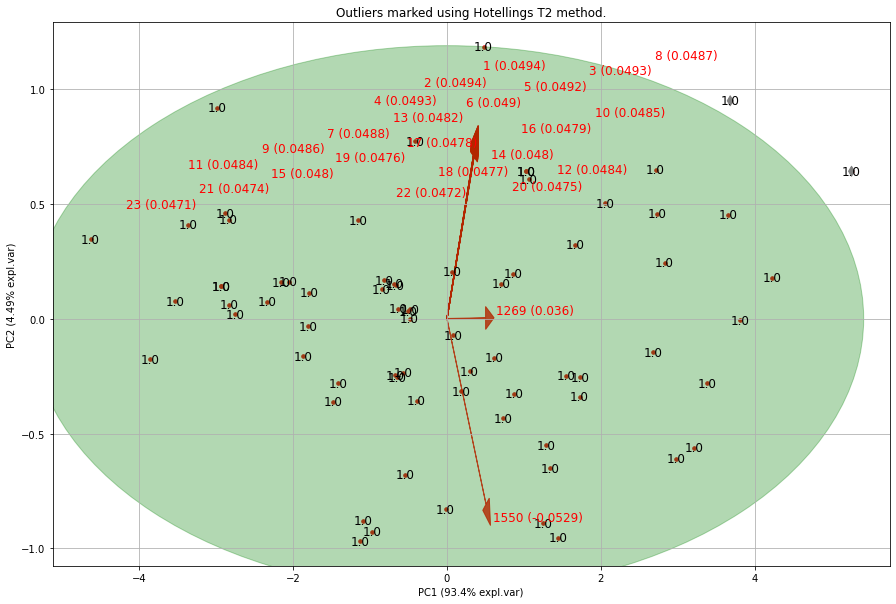

In [176]:
# import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from pca import pca

pca_model = pca(detect_outliers=['ht2', 'spe'],n_std=2.5 )

results = pca_model.fit_transform(X)
#PCA(n_components=5)
# Plot Hotellings T2
pca_model.biplot(SPE=True, hotellingt2=True, title='Outliers marked using Hotellings T2 method.', legend=False)

In [412]:
# df_pretreat = df.iloc[:, 1:-2]
# df_pretreat['Umidade'] = df['Moisture Content (%)']
# df_pretreat['Oleo'] = df['Fat Content (%)']

In [423]:
# ###Remove maybe 39 and 42
# df_pretreat.drop([39,42], inplace=True)

In [12]:
df_pretreat['class'] = 0
for index, row in df_pretreat.iterrows():
    if row['Umidade'] < 8:
        df_pretreat.loc[index, 'class'] = 0
    elif row['Umidade'] < 9:
        df_pretreat.loc[index, 'class'] = 1
    elif row['Umidade'] < 10:
        df_pretreat.loc[index, 'class'] = 2
    else:
        df_pretreat.loc[index, 'class'] = 3

In [29]:
##Derive

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


y = df_pretreat[['Umidade','Oleo','class']]
## Do not take the reference value and the class
X = df_pretreat.values[:, :-3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])


col = [0,2,3,4,5,7,10,11,13,14,15,17,20,24,26,29,30,31,35,36,40,41,42,44,48,49,50,58,64,67,70,71,72,73,74,76,78,79,81,82,83,86,87,89,95,99,100,101,108,109,110,111,112,113,114,115,117,118,119,122,124,125,128,129,136,137,139,140,142,143,145,147,148,150,151,153,155,159,164,168,169,170,171,173,176,177,185,186,188,189,191,192,194,197,199,200,202,209,212,214,215,216,218,219,222,227,228,231,232,234,235,236,238,239,242,244,246,248,252,253,255,257,260,261,272,276,277,283,284,285,290,293,295,297,300,303,304,305,306,310,311,314,315,318,320,322,325,326,328,329,331,332,333,334,336,338,346,347,348,349,350,352,353,354,355,357,362,363,364,367,368,374,375,378,381,383,384,385,386,387,389,392,393,395,396,401,402,403,406,409,410,412,417,418,421,428,429,430,432,433,434,435,438,441,443,444,450,453,456,457,459,462,464,465,466,467,469,477,485,488,490,496,497,500,503,504,505,511,514,515,516,520,522,523,530,536,538,539,541,543,544,545,546,562,564,565,566,567,570,571,572,574,575,576,577,578,579,580,582,583,585,586,587,588,589,592,593,594,595,597,598,602,604,609,612,615,622,623,626,627,632,634,637,639,644,645,646,648,649,653,656,657,658,662,663,666,668,669,670,673,677,680,683,684,686,688,690,691,696,699,704,705,707,713,720,721,723,724,725,726,727,729,736,750,752,768,770,772,774,775,778,779,782,783,784,786,787,788,794,798,800,806,809,813,814,824,825,830,831,838,841,843,844,847,849,851,852,856,858,859,861,862,863,864,865,866,877,884,885,886,894,896,897,901,902,906,907,910,916,918,925,932,933,935,939,941,944,946,947,951,953,960,961,970,971,977,981,984,989,992,994,995,997,999,1000,1001,1005,1008,1015,1022,1027,1029,1030,1031,1034,1035,1036,1037,1039,1045,1048,1052,1054,1060,1061,1062,1069,1071,1072,1073,1075,1076,1078,1081,1084,1086,1092,1094,1095,1098,1100,1104,1109,1111,1113,1114,1115,1117,1119,1120,1121,1122,1126,1127,1128,1134,1136,1137,1138,1139,1140,1143,1144,1145,1146,1147,1148,1149,1152,1153,1154,1157,1158,1159,1160,1161,1166,1168,1169,1171,1174,1176,1179,1180,1185,1187,1188,1189,1191,1197,1198,1199,1202,1204,1206,1212,1213,1220,1224,1229,1231,1232,1234,1237,1238,1239,1240,1241,1243,1244,1245,1246,1249,1252,1255,1256,1257,1259,1262,1263,1264,1267,1268,1269,1271,1274,1277,1281,1284,1285,1286,1290,1291,1293,1297,1299,1303,1305,1306,1311,1312,1314,1317,1319,1320,1322,1324,1327,1329,1331,1333,1334,1337,1340,1341,1344,1347,1348,1349,1354,1357,1358,1359,1361,1368,1369,1370,1371,1373,1374,1375,1377,1378,1379,1383,1384,1386,1389,1391,1395,1399,1400,1401,1402,1405,1406,1407,1412,1422,1424,1427,1429,1430,1431,1432,1433,1445,1446,1449,1451,1452,1455,1464,1466,1467,1468,1470,1472,1474,1475,1476,1477,1479,1482,1483,1484,1489,1492,1501,1503,1506,1509,1512,1516,1518,1520,1521,1523,1524,1525,1530,1533,1534,1535,1536,1538,1540,1543,1544,1547,1549,1550,1551,1554,1555]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))
col = [6,   7,  14,  15,  18,  23,  25,  26,  27,  28,  29,  32,  34,
        36,  41,  44,  45,  46,  47,  52,  56,  59,  60,  61,  62,  63,
        67,  68,  69,  70,  72,  73,  74,  76,  80,  81,  83,  85,  87,
        91,  93,  95,  96,  98,  99, 100, 102, 103, 105, 106, 109, 111,
       115, 117, 120, 125, 126, 129, 130, 131, 132, 133, 136, 137, 142,
       143, 144, 145, 147, 150, 151, 152, 153, 157, 162, 164, 167, 168,
       170, 180, 181, 182, 183, 185, 189, 190, 191, 193, 194, 195, 197,
       200, 201, 202, 203, 207, 208, 210, 217, 219, 222, 228, 229, 231,
       233, 234, 235, 239, 244, 247, 252, 256, 260, 262, 263, 270, 271,
       273, 274, 281, 282, 284, 287, 289, 294, 295, 296, 299, 305, 308,
       312, 322, 325, 327, 332, 334, 335, 336, 342, 343, 345, 346, 350,
       352, 353, 361, 372, 376, 380, 387, 390, 394, 398, 400, 402, 406,
       407, 408, 410, 411, 413, 414, 421, 422, 423, 424, 425, 426, 427,
       428, 429, 431, 435, 436, 438, 441, 442, 444, 445, 453, 454, 455,
       456, 460, 461, 465, 467, 469, 472, 475, 477, 479, 480, 482, 484,
       489, 490, 493, 494, 498, 499, 500, 502, 509, 511, 513, 516, 517,
       518, 521, 523, 524, 527, 529, 533, 535, 536, 542, 544, 546, 551,
       552, 554, 555, 556, 557, 558, 561, 562, 564, 567, 568, 573, 576,
       580, 581, 584, 586, 589, 590, 591, 593, 594, 597, 598, 600, 601,
       602, 607, 608, 610, 611, 613, 614, 615, 616, 619, 621, 623, 624,
       626, 628, 629, 630, 632, 633, 635, 637, 644, 647, 650, 653, 657,
       662, 669, 670, 671, 674, 675, 679, 680, 682, 684, 685, 690, 691,
       693, 697, 698, 700, 704, 706, 707, 708, 709, 710, 715, 720, 721,
       724, 726, 729, 734, 735, 736, 738, 740, 742, 743, 744, 745, 747,
       748, 749, 750, 751, 752, 755, 758, 760, 763, 767, 770, 771, 772,
       775, 779, 784, 786, 788, 790, 795, 801, 802, 805, 806, 807, 808,
       810, 811, 813, 816, 819, 820, 821, 822, 823, 824, 827, 833, 834,
       837, 838, 840, 842, 843, 848, 850, 855, 858, 860, 861, 863, 864,
       865, 866, 872, 873, 874, 880, 882, 883, 885, 887, 889, 892, 897,
       899, 900, 901, 902, 903, 904, 906, 907, 908, 909]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [ 0,   1,   6,   7,   9,  16,  17,  18,  20,  22,  23,  27,  28,
        31,  32,  37,  39,  42,  43,  48,  50,  51,  52,  53,  56,  58,
        60,  67,  69,  70,  71,  75,  77,  79,  84,  89,  90,  91,  93,
        96,  98,  99, 101, 102, 103, 104, 108, 110, 113, 114, 119, 121,
       122, 124, 126, 127, 131, 132, 133, 136, 138, 142, 143, 148, 151,
       153, 154, 159, 162, 165, 166, 167, 169, 171, 172, 174, 175, 176,
       177, 178, 185, 186, 187, 190, 193, 197, 200, 202, 203, 208, 214,
       215, 218, 219, 224, 226, 228, 232, 233, 234, 236, 237, 239, 242,
       248, 249, 250, 252, 255, 258, 263, 266, 268, 269, 271, 272, 275,
       279, 283, 284, 286, 289, 291, 292, 295, 296, 297, 300, 302, 303,
       304, 305, 308, 310, 313, 315, 316, 322, 325, 328, 329, 331, 332,
       333, 337, 339, 341, 342, 344, 347, 350, 352, 354, 356, 362, 363,
       364, 368, 369, 375, 376, 378, 381, 384, 389, 390, 394, 395, 396,
       398, 399, 402, 403, 407, 408, 410, 413, 418, 420, 421, 422, 423,
       426, 428, 430, 432, 433, 437, 438, 439, 440, 441, 443, 444, 448,
       449, 450, 451, 452, 454, 455, 460, 463, 468, 470, 471, 474, 476,
       478, 479, 480, 482, 483, 485, 486, 488, 489, 490, 492, 493, 494,
       498, 500, 502, 503, 510, 511, 513, 514, 518]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [ 1,   3,   8,  12,  13,  15,  18,  20,  22,  24,  25,  26,  28,
        31,  35,  37,  38,  39,  40,  41,  42,  46,  48,  49,  53,  54,
        60,  61,  62,  64,  68,  69,  71,  72,  73,  75,  80,  85,  88,
        96, 104, 108, 111, 113, 114, 116, 118, 120, 123, 127, 132, 133,
       134, 138, 141, 143, 144, 149, 151, 152, 154, 155, 160, 162, 164,
       165, 169, 173, 180, 182, 186, 187, 194, 196, 197, 202, 203, 207,
       208, 209, 211, 212, 213, 214, 215, 218, 224, 227, 228, 230, 232,
       233, 235, 237, 242, 245, 246, 248, 250, 252, 260, 261, 267, 268,
       270, 271, 272, 274, 276, 279, 282, 288, 290, 292, 294]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [  14,  16,  23,  32,  39,  41,  43,  45,  51,  52,  56,  57,  58,
        66,  67,  78,  79,  98, 103, 106, 109, 117, 119, 123, 124, 127,
       129, 132, 133, 134, 136, 137, 140, 141, 145, 147, 149, 150, 156,
       159, 162, 163, 166, 167, 168, 169, 171]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [  0,   1,   4,   5,   6,  15,  17,  19,  29,  30,  39,  40,  43,
        48,  61,  70,  78,  79,  87,  88,  89,  92,  95,  97,  99, 102,
       103, 107, 109, 112, 121, 122, 123, 127, 131]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [ 3, 15, 16, 18, 25, 26, 27, 31, 32, 36, 37, 38, 40, 48, 54, 55, 58,
       59, 60, 61, 63, 65, 89]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

col = [  4,  5,  7, 10, 19, 23, 32, 33, 36, 40, 43, 45]
X_train = (np.delete(X_train, col,1))
X_test = (np.delete(X_test, col,1))
X = (np.delete(X, col,1))

# col = [  16, 31, 34, 39, 40, 60, 61, 62]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))


# col = [ 27, 31, 40, 46]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))


# col = [ 7, 35, 46, 47, 49]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 41]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))


# X_train_snv = msc(X_train)
# X_#test_snv = msc(X_test)

y_train_oleo = y_train['Umidade']


y_test_oleo = y_test['Umidade']

#X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
#X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# X_train_snv = msc(X_train)
# X_test_snv = msc(X_test)

# mean centre correction
#X_mc = mc(X1)

##Standard Normal Variate

# Xsnv = snv(X_train)

In [17]:
# ##Derive

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split


# y = df_pretreat[['Umidade','Oleo','class']]
# ## Do not take the reference value and the class
# X = df_pretreat.values[:, :-3]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0,stratify=y['class'])


# col = [0,2,3,4,5,7,10,11,13,14,15,17,20,24,26,29,30,31,35,36,40,41,42,44,48,49,50,58,64,67,70,71,72,73,74,76,78,79,81,82,83,86,87,89,95,99,100,101,108,109,110,111,112,113,114,115,117,118,119,122,124,125,128,129,136,137,139,140,142,143,145,147,148,150,151,153,155,159,164,168,169,170,171,173,176,177,185,186,188,189,191,192,194,197,199,200,202,209,212,214,215,216,218,219,222,227,228,231,232,234,235,236,238,239,242,244,246,248,252,253,255,257,260,261,272,276,277,283,284,285,290,293,295,297,300,303,304,305,306,310,311,314,315,318,320,322,325,326,328,329,331,332,333,334,336,338,346,347,348,349,350,352,353,354,355,357,362,363,364,367,368,374,375,378,381,383,384,385,386,387,389,392,393,395,396,401,402,403,406,409,410,412,417,418,421,428,429,430,432,433,434,435,438,441,443,444,450,453,456,457,459,462,464,465,466,467,469,477,485,488,490,496,497,500,503,504,505,511,514,515,516,520,522,523,530,536,538,539,541,543,544,545,546,562,564,565,566,567,570,571,572,574,575,576,577,578,579,580,582,583,585,586,587,588,589,592,593,594,595,597,598,602,604,609,612,615,622,623,626,627,632,634,637,639,644,645,646,648,649,653,656,657,658,662,663,666,668,669,670,673,677,680,683,684,686,688,690,691,696,699,704,705,707,713,720,721,723,724,725,726,727,729,736,750,752,768,770,772,774,775,778,779,782,783,784,786,787,788,794,798,800,806,809,813,814,824,825,830,831,838,841,843,844,847,849,851,852,856,858,859,861,862,863,864,865,866,877,884,885,886,894,896,897,901,902,906,907,910,916,918,925,932,933,935,939,941,944,946,947,951,953,960,961,970,971,977,981,984,989,992,994,995,997,999,1000,1001,1005,1008,1015,1022,1027,1029,1030,1031,1034,1035,1036,1037,1039,1045,1048,1052,1054,1060,1061,1062,1069,1071,1072,1073,1075,1076,1078,1081,1084,1086,1092,1094,1095,1098,1100,1104,1109,1111,1113,1114,1115,1117,1119,1120,1121,1122,1126,1127,1128,1134,1136,1137,1138,1139,1140,1143,1144,1145,1146,1147,1148,1149,1152,1153,1154,1157,1158,1159,1160,1161,1166,1168,1169,1171,1174,1176,1179,1180,1185,1187,1188,1189,1191,1197,1198,1199,1202,1204,1206,1212,1213,1220,1224,1229,1231,1232,1234,1237,1238,1239,1240,1241,1243,1244,1245,1246,1249,1252,1255,1256,1257,1259,1262,1263,1264,1267,1268,1269,1271,1274,1277,1281,1284,1285,1286,1290,1291,1293,1297,1299,1303,1305,1306,1311,1312,1314,1317,1319,1320,1322,1324,1327,1329,1331,1333,1334,1337,1340,1341,1344,1347,1348,1349,1354,1357,1358,1359,1361,1368,1369,1370,1371,1373,1374,1375,1377,1378,1379,1383,1384,1386,1389,1391,1395,1399,1400,1401,1402,1405,1406,1407,1412,1422,1424,1427,1429,1430,1431,1432,1433,1445,1446,1449,1451,1452,1455,1464,1466,1467,1468,1470,1472,1474,1475,1476,1477,1479,1482,1483,1484,1489,1492,1501,1503,1506,1509,1512,1516,1518,1520,1521,1523,1524,1525,1530,1533,1534,1535,1536,1538,1540,1543,1544,1547,1549,1550,1551,1554,1555]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))
# col = [6,   7,  14,  15,  18,  23,  25,  26,  27,  28,  29,  32,  34,
#         36,  41,  44,  45,  46,  47,  52,  56,  59,  60,  61,  62,  63,
#         67,  68,  69,  70,  72,  73,  74,  76,  80,  81,  83,  85,  87,
#         91,  93,  95,  96,  98,  99, 100, 102, 103, 105, 106, 109, 111,
#        115, 117, 120, 125, 126, 129, 130, 131, 132, 133, 136, 137, 142,
#        143, 144, 145, 147, 150, 151, 152, 153, 157, 162, 164, 167, 168,
#        170, 180, 181, 182, 183, 185, 189, 190, 191, 193, 194, 195, 197,
#        200, 201, 202, 203, 207, 208, 210, 217, 219, 222, 228, 229, 231,
#        233, 234, 235, 239, 244, 247, 252, 256, 260, 262, 263, 270, 271,
#        273, 274, 281, 282, 284, 287, 289, 294, 295, 296, 299, 305, 308,
#        312, 322, 325, 327, 332, 334, 335, 336, 342, 343, 345, 346, 350,
#        352, 353, 361, 372, 376, 380, 387, 390, 394, 398, 400, 402, 406,
#        407, 408, 410, 411, 413, 414, 421, 422, 423, 424, 425, 426, 427,
#        428, 429, 431, 435, 436, 438, 441, 442, 444, 445, 453, 454, 455,
#        456, 460, 461, 465, 467, 469, 472, 475, 477, 479, 480, 482, 484,
#        489, 490, 493, 494, 498, 499, 500, 502, 509, 511, 513, 516, 517,
#        518, 521, 523, 524, 527, 529, 533, 535, 536, 542, 544, 546, 551,
#        552, 554, 555, 556, 557, 558, 561, 562, 564, 567, 568, 573, 576,
#        580, 581, 584, 586, 589, 590, 591, 593, 594, 597, 598, 600, 601,
#        602, 607, 608, 610, 611, 613, 614, 615, 616, 619, 621, 623, 624,
#        626, 628, 629, 630, 632, 633, 635, 637, 644, 647, 650, 653, 657,
#        662, 669, 670, 671, 674, 675, 679, 680, 682, 684, 685, 690, 691,
#        693, 697, 698, 700, 704, 706, 707, 708, 709, 710, 715, 720, 721,
#        724, 726, 729, 734, 735, 736, 738, 740, 742, 743, 744, 745, 747,
#        748, 749, 750, 751, 752, 755, 758, 760, 763, 767, 770, 771, 772,
#        775, 779, 784, 786, 788, 790, 795, 801, 802, 805, 806, 807, 808,
#        810, 811, 813, 816, 819, 820, 821, 822, 823, 824, 827, 833, 834,
#        837, 838, 840, 842, 843, 848, 850, 855, 858, 860, 861, 863, 864,
#        865, 866, 872, 873, 874, 880, 882, 883, 885, 887, 889, 892, 897,
#        899, 900, 901, 902, 903, 904, 906, 907, 908, 909]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 0,   1,   6,   7,   9,  16,  17,  18,  20,  22,  23,  27,  28,
#         31,  32,  37,  39,  42,  43,  48,  50,  51,  52,  53,  56,  58,
#         60,  67,  69,  70,  71,  75,  77,  79,  84,  89,  90,  91,  93,
#         96,  98,  99, 101, 102, 103, 104, 108, 110, 113, 114, 119, 121,
#        122, 124, 126, 127, 131, 132, 133, 136, 138, 142, 143, 148, 151,
#        153, 154, 159, 162, 165, 166, 167, 169, 171, 172, 174, 175, 176,
#        177, 178, 185, 186, 187, 190, 193, 197, 200, 202, 203, 208, 214,
#        215, 218, 219, 224, 226, 228, 232, 233, 234, 236, 237, 239, 242,
#        248, 249, 250, 252, 255, 258, 263, 266, 268, 269, 271, 272, 275,
#        279, 283, 284, 286, 289, 291, 292, 295, 296, 297, 300, 302, 303,
#        304, 305, 308, 310, 313, 315, 316, 322, 325, 328, 329, 331, 332,
#        333, 337, 339, 341, 342, 344, 347, 350, 352, 354, 356, 362, 363,
#        364, 368, 369, 375, 376, 378, 381, 384, 389, 390, 394, 395, 396,
#        398, 399, 402, 403, 407, 408, 410, 413, 418, 420, 421, 422, 423,
#        426, 428, 430, 432, 433, 437, 438, 439, 440, 441, 443, 444, 448,
#        449, 450, 451, 452, 454, 455, 460, 463, 468, 470, 471, 474, 476,
#        478, 479, 480, 482, 483, 485, 486, 488, 489, 490, 492, 493, 494,
#        498, 500, 502, 503, 510, 511, 513, 514, 518]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 1,   3,   8,  12,  13,  15,  18,  20,  22,  24,  25,  26,  28,
#         31,  35,  37,  38,  39,  40,  41,  42,  46,  48,  49,  53,  54,
#         60,  61,  62,  64,  68,  69,  71,  72,  73,  75,  80,  85,  88,
#         96, 104, 108, 111, 113, 114, 116, 118, 120, 123, 127, 132, 133,
#        134, 138, 141, 143, 144, 149, 151, 152, 154, 155, 160, 162, 164,
#        165, 169, 173, 180, 182, 186, 187, 194, 196, 197, 202, 203, 207,
#        208, 209, 211, 212, 213, 214, 215, 218, 224, 227, 228, 230, 232,
#        233, 235, 237, 242, 245, 246, 248, 250, 252, 260, 261, 267, 268,
#        270, 271, 272, 274, 276, 279, 282, 288, 290, 292, 294]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [  14,  16,  23,  32,  39,  41,  43,  45,  51,  52,  56,  57,  58,
#         66,  67,  78,  79,  98, 103, 106, 109, 117, 119, 123, 124, 127,
#        129, 132, 133, 134, 136, 137, 140, 141, 145, 147, 149, 150, 156,
#        159, 162, 163, 166, 167, 168, 169, 171]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [  0,   1,   4,   5,   6,  15,  17,  19,  29,  30,  39,  40,  43,
#         48,  61,  70,  78,  79,  87,  88,  89,  92,  95,  97,  99, 102,
#        103, 107, 109, 112, 121, 122, 123, 127, 131]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [ 3, 15, 16, 18, 25, 26, 27, 31, 32, 36, 37, 38, 40, 48, 54, 55, 58,
#        59, 60, 61, 63, 65, 89]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))

# col = [  5,  8, 23, 25, 29, 34, 36, 37, 40, 41, 42, 56, 57, 60, 74]
# X_train = (np.delete(X_train, col,1))
# X_test = (np.delete(X_test, col,1))
# X = (np.delete(X, col,1))




# # col = [  0,  2, 17, 40, 45]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# ####################################################
# # col = [ 27, 31, 40, 46]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))


# # col = [ 7, 35, 46, 47, 49]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))

# # col = [ 41]
# # X_train = (np.delete(X_train, col,1))
# # X_test = (np.delete(X_test, col,1))
# # X = (np.delete(X, col,1))


# # X_train_snv = msc(X_train)
# # X_#test_snv = msc(X_test)

# y_train_oleo = y_train['Umidade']


# y_test_oleo = y_test['Umidade']

# #X1 = savgol_filter(X_train, 23, polyorder=2, deriv=2)
# #X2 = savgol_filter(X_test, 23, polyorder=2, deriv=2)

# # X_train_snv = msc(X_train)
# # X_test_snv = msc(X_test)

# # mean centre correction
# #X_mc = mc(X1)

# ##Standard Normal Variate

# # Xsnv = snv(X_train)

In [64]:
# ##Pour X
# X = df_pretreat.values[:, :-3]
# # col = [3,8,11,12,15,17,18,20,22,23,24,31,33,37,38,41,42,43,44,49,50,51,54,56,59,65,66,67,68,69,70,73,75,77,83,85,86,87,88,93,94,95,97,98,99,102,108,109,110,115,120,121,125,126,129,131,133,136,138,140,144,145,146,148,150,155,157,159,160,161,165,166,170,171,172,177,178,179,182,186,187,188,190,191,193,195,197,202,203,205,208,209,210,211,212,213,214,217,221,223,224,226,227,229,231,232,236,244,246,248,251,252,254,256,257,260,263,266,267,271,272,277,278,283,284,285,288,289,290,293,296,297,298,301,305,307,308,312,314,317,318,320,322,323,327,332,336,337,338,347,348,349,351,356,360,361,362,363,364,365,366,370,372,374,376,382,383,384,387,388,389,391,392,395,397,402,403,404,405,409,410,411,413,414,415,418,419,420,422,424,425,426,427,428,429,432,433,436,440,441,442,444,445,446,449,452,454,455,457,459,461,462,463,466,468,475,479,481,482,483,487,489,493,495,499,500,504,506,507,510,512,514,518,519,521,525,527,531,534,535,536,539,541,542,543,544,545,546,547,548,554,557,560,561,562,564,565,567,568,569,570,573,574,575,576,577,579,580,581,582,585,586,587,588,591,592,593,594,595,596,597,598,599,601,602,607,608,609,610,611,612,614,616,618,621,622,624,625,626,630,631,632,634,638,639,643,645,648,649,651,655,656,661,662,663,667,668,670,671,676,678,683,686,687,688,690,691,692,693,695,701,704,705,706,707,713,714,715,720,721,723,729,731,733,734,736,738,739,742,743,744,748,749,751,752,754,756,757,758,762,764,766,770,772,773,775,777,780,784,786,793,800,801,802,803,804,805,816,818,819,821,823,827,829,832,833,834,835,836,838,840,842,844,846,850,851,853,854,856,858,860,861,873,874,877,884,886,887,888,890,895,896,897,898,903,904,907,908,909,911,913,914,916,917,918,921,922,923,926,929,930,931,933,937,938,942,943,946,948,949,950,956,957,958,961,962,964,965,966,970,972,975,979,980,981,982,984,987,989,990,991,993,996,997,998,999,1000,1002,1006,1012,1015,1016,1018,1020,1021,1024,1027,1028,1030,1032,1036,1037,1038,1039,1043,1045,1048,1049,1051,1052,1053,1054,1061,1065,1067,1070,1071,1072,1073,1074,1075,1076,1078,1080,1083,1085,1086,1090,1091,1099,1100,1101,1104,1106,1109,1111,1114,1116,1117,1118,1120,1121,1126,1127,1128,1129,1131,1132,1133,1135,1136,1137,1139,1141,1142,1144,1145,1146,1148,1149,1151,1152,1153,1154,1159,1163,1164,1165,1176,1180,1181,1183,1185,1188,1189,1190,1194,1195,1198,1199,1203,1206,1207,1208,1209,1214,1215,1220,1226,1227,1228,1232,1235,1241,1243,1246,1249,1251,1254,1255,1259,1260,1262,1263,1266,1270,1272,1273,1274,1278,1279,1280,1282,1284,1285,1286,1287,1288,1292,1296,1298,1307,1308,1310,1313,1315,1317,1318,1320,1322,1323,1328,1335,1336,1338,1339,1344,1345,1346,1348,1353,1354,1355,1356,1357,1360,1361,1366,1370,1371,1372,1373,1375,1376,1378,1382,1384,1385,1387,1391,1394,1402,1403,1404,1406,1407,1414,1415,1417,1418,1420,1421,1424,1426,1430,1432,1433,1434,1438,1439,1440,1442,1443,1444,1448,1449,1450,1451,1453,1457,1459,1462,1463,1466,1467,1468,1471,1472,1473,1474,1475,1478,1479,1481,1482,1483,1485,1487,1488,1490,1494,1496,1498,1500,1502,1504,1509,1510,1511,1513,1514,1519,1521,1528,1529,1532,1534,1536,1537,1538,1544,1547,1549,1550,1551,1553,1555,1556]
# col = [4,6,10,12,19,23,30,32,33,35,36,37,41,42,44,49,52,54,55,63,65,67,70,71,72,74,76,77,80,81,82,85,87,89,93,98,101,108,111,112,115,116,118,120,121,122,123,124,129,131,134,139,147,148,149,150,151,153,155,157,158,159,160,161,163,165,166,168,170,173,176,177,178,179,181,182,187,188,190,191,192,193,196,197,199,203,204,205,207,209,212,222,223,228,229,231,233,235,236,237,239,246,248,249,251,259,263,264,268,270,271,274,279,282,284,287,292,293,295,298,300,301,302,305,310,313,318,322,326,327,331,334,338,339,341,343,348,350,353,354,357,358,359,360,362,365,367,368,371,373,374,375,376,383,384,386,388,389,391,392,393,394,395,396,401,402,403,405,406,410,411,412,414,415,416,417,418,419,420,421,422,424,425,426,428,429,431,432,433,434,435,437,438,439,443,444,445,447,453,454,456,458,461,462,466,471,473,475,478,479,480,481,482,485,488,489,491,492,496,501,507,509,511,512,514,515,519,524,529,530,532,535,538,539,541,542,544,547,548,551,554,555,556,558,561,562,563,564,566,568,569,570,571,574,575,577,578,579,580,581,583,585,586,587,589,590,591,593,595,597,598,599,601,602,603,605,607,608,609,610,613,615,618,619,620,621,622,626,627,630,632,633,635,637,639,644,646,648,652,656,657,658,662,665,667,671,674,675,677,679,681,682,683,685,686,687,688,690,691,692,693,695,696,697,699,702,707,712,713,715,718,719,723,725,726,727,728,733,740,741,743,744,746,750,752,754,757,758,763,765,766,767,768,769,772,773,774,775,776,777,780,781,785,786,789,791,792,793,794,799,800,801,807,808,809,810,811,812,815,816,819,822,823,824,825,827,831,834,835,839,840,844,845,846,848,850,851,852,853,854,861,863,864,865,866,868,870,871,872,873,874,875,877,879,882,884,885,886,887,889,890,891,893,895,897,898,899,903,904,905,906,908,915,917,918,921,923,924,925,927,928,929,933,934,936,940,941,942,944,945,946,947,948,949,951,952,955,956,958,960,962,965,966,970,974,975,976,977,978,979,981,984,988,992,993,996,1000,1002,1003,1004,1007,1012,1014,1016,1017,1018,1021,1022,1024,1026,1028,1030,1032,1036,1038,1041,1042,1044,1048,1050,1053,1056,1057,1060,1062,1063,1066,1067,1068,1070,1073,1077,1080,1083,1084,1085,1087,1088,1089,1090,1091,1093,1095,1096,1098,1099,1105,1106,1108,1109,1110,1111,1113,1114,1115,1121,1122,1123,1124,1125,1126,1129,1131,1132,1133,1134,1137,1138,1141,1142,1144,1145,1149,1150,1152,1155,1158,1159,1163,1164,1169,1170,1172,1174,1178,1180,1181,1182,1183,1186,1188,1191,1193,1194,1195,1201,1202,1206,1208,1210,1215,1217,1219,1223,1226,1227,1229,1230,1232,1234,1240,1241,1242,1247,1249,1258,1262,1263,1265,1268,1269,1270,1274,1275,1276,1277,1278,1280,1283,1284,1287,1289,1291,1294,1295,1296,1297,1299,1300,1301,1304,1308,1311,1315,1317,1319,1323,1324,1326,1332,1338,1339,1340,1343,1344,1345,1346,1347,1351,1353,1354,1355,1357,1363,1364,1366,1367,1368,1371,1381,1382,1383,1385,1386,1389,1391,1396,1397,1402,1405,1406,1408,1409,1410,1415,1416,1417,1419,1420,1427,1429,1431,1432,1435,1436,1437,1438,1442,1443,1444,1445,1447,1448,1449,1450,1452,1454,1457,1459,1462,1463,1465,1466,1467,1470,1471,1472,1476,1478,1480,1486,1488,1490,1491,1494,1497,1499,1500,1501,1507,1508,1509,1511,1514,1516,1518,1522,1525,1527,1528,1533,1534,1541,1542,1545,1546,1548,1550,1553,1556]
# X = (np.delete(X, col,1))

# col = [0,   1,   4,   6,   9,  14,  15,  16,  18,  25,  26,  27,  30,
#         33,  35,  37,  38,  39,  40,  44,  45,  51,  52,  53,  54,  58,
#         72,  73,  75,  76,  77,  78,  79,  82,  83,  85,  86,  88,  90,
#         91,  92,  93,  94,  99, 102, 108, 109, 110, 112, 113, 114, 115,
#        116, 117, 118, 119, 122, 125, 128, 129, 131, 133, 135, 143, 144,
#        145, 147, 148, 150, 151, 152, 159, 161, 163, 164, 165, 173, 176,
#        179, 180, 183, 184, 185, 189, 190, 193, 197, 199, 200, 204, 205,
#        208, 209, 210, 212, 213, 216, 217, 219, 220, 221, 223, 226, 227,
#        228, 231, 232, 236, 239, 242, 243, 256, 257, 259, 266, 268, 273,
#        277, 282, 287, 288, 296, 300, 301, 303, 304, 308, 317, 318, 319,
#        324, 327, 332, 333, 336, 338, 340, 341, 342, 344, 349, 350, 351,
#        354, 360, 361, 363, 366, 367, 374, 375, 377, 378, 379, 380, 383,
#        385, 387, 388, 390, 391, 393, 400, 402, 406, 408, 409, 411, 412,
#        413, 414, 418, 420, 421, 422, 425, 427, 430, 431, 432, 433, 434,
#        435, 439, 441, 443, 446, 447, 449, 450, 452, 454, 457, 458, 463,
#        467, 473, 474, 475, 477, 479, 483, 484, 486, 488, 490, 493, 495,
#        496, 497, 498, 501, 504, 506, 509, 510, 511, 515, 516, 524, 526,
#        527, 528, 529, 530, 532, 534, 535, 541, 544, 545, 553, 554, 555,
#        563, 566, 571, 572, 578, 580, 582, 586, 587, 588, 589, 590, 591,
#        592, 595, 596, 597, 599, 600, 601, 603, 605, 607, 608, 615, 616,
#        618, 620, 622, 626, 629, 630, 631, 642, 643, 644, 648, 649, 650,
#        653, 654, 655, 657, 660, 662, 663, 664, 668, 669, 671, 672, 675,
#        677, 679, 681, 682, 684, 686, 688, 689, 690, 691, 695, 696, 697,
#        699, 700, 702, 703, 704, 705, 706, 712, 713, 715, 716, 723, 724,
#        726, 727, 730, 731, 732, 736, 737, 738, 739, 740, 746, 748, 752,
#        756, 759, 761, 765, 766, 767, 772, 773, 775, 776, 778, 781, 785,
#        786, 791, 792, 794, 796, 798, 801, 804, 807, 817, 818, 821, 824,
#        826]
# X = (np.delete(X, col,1))

# col = [ 1,   3,   7,   8,   9,  14,  16,  17,  20,  23,  27,  28,  29,
#         30,  31,  32,  36,  38,  39,  41,  48,  51,  54,  56,  58,  59,
#         60,  61,  63,  64,  67,  71,  72,  73,  75,  76,  78,  81,  82,
#         84,  87,  89,  90,  93,  94,  96,  97,  98,  99, 101, 105, 109,
#        111, 112, 115, 117, 118, 119, 121, 122, 124, 126, 131, 133, 136,
#        137, 139, 140, 144, 146, 149, 150, 152, 153, 159, 162, 166, 167,
#        168, 171, 173, 182, 183, 184, 187, 188, 189, 190, 192, 195, 197,
#        198, 200, 208, 211, 212, 213, 214, 215, 217, 220, 221, 223, 230,
#        237, 238, 239, 240, 242, 247, 249, 251, 255, 256, 258, 263, 264,
#        267, 269, 272, 273, 278, 281, 282, 284, 286, 289, 291, 294, 295,
#        297, 299, 300, 301, 303, 306, 307, 308, 309, 310, 312, 316, 320,
#        322, 324, 325, 326, 328, 333, 334, 335, 339, 341, 342, 343, 347,
#        349, 350, 351, 353, 356, 361, 363, 368, 371, 376, 379, 380, 382,
#        391, 394, 395, 402, 403, 406, 407, 411, 412, 413, 414, 415, 416,
#        423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 438, 439, 440,
#        442, 445, 449, 453, 456, 457, 458, 459, 466, 470, 471, 472]
# X = (np.delete(X, col,1))
# col = [1,   3,   4,   6,   8,  11,  14,  15,  18,  19,  21,  23,  25,
#         26,  28,  32,  35,  40,  44,  46,  47,  48,  51,  56,  57,  59,
#         62,  63,  64,  65,  69,  72,  77,  85,  86,  90,  94,  96,  99,
#        100, 101, 102, 105, 107, 108, 115, 117, 119, 120, 123, 126, 127,
#        129, 130, 131, 132, 134, 143, 145, 149, 152, 155, 158, 162, 165,
#        172, 174, 178, 179, 180, 183, 186, 195, 197, 200, 201, 205, 206,
#        207, 210, 214, 215, 217, 221, 223, 225, 226, 227, 228, 229, 233,
#        234, 235, 236, 240, 242, 243, 244, 245, 248, 254, 255, 256, 260,
#        264, 265, 267]
# X = (np.delete(X, col,1))



# col = [1,   5,   8,   9,  10,  15,  18,  25,  28,  29,  35,  39,  41,
#         43,  44,  51,  53,  54,  57,  61,  62,  63,  64,  74,  77,  80,
#         81,  94,  98,  99, 100, 102, 103, 107, 109, 111, 117, 119, 124,
#        127, 128, 130, 142, 152, 155, 157, 159]
# X = (np.delete(X, col,1))
# # col = [7,  14,  19,  23,  24,  40,  41,  46,  47,  48,  49,  52,  56,
# #         69,  72,  74,  79,  82,  91,  92,  97, 102, 104, 110]
# # X = (np.delete(X, col,1))


In [58]:
# Import PySwarms
import pyswarms as ps

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-04-30 22:30:31,802 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.202
2023-04-30 22:45:14,437 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.20249051946141425, best pos: [1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0
 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0
 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1
 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 

In [27]:
# Import PySwarms
import pyswarms as ps

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.9, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X_train.shape[1] # dimensions should be the number of features

optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=100, verbose=2)
optimizer.reset()

2023-05-03 10:23:34,569 - pyswarms.discrete.binary - INFO - Optimize for 100 iters with {'c1': 2, 'c2': 2, 'w': 0.9, 'k': 20, 'p': 2}
pyswarms.discrete.binary: 100%|██████████|100/100, best_cost=0.0964
2023-05-03 10:36:07,050 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.09640536532965739, best pos: [0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [28]:
np.where(pos == 0)[0]

array([ 0,  2, 17, 40, 45], dtype=int64)

In [37]:
print(X_train.shape)
print(X_test.shape)

(61, 60)
(11, 60)


In [54]:
with open("Col_to_delete_2023-04-30_Cacao_moisture_X_train_test.txt", "w") as txt_file:
    for line in np.where(pos == 0)[0]:
        txt_file.write(str(line)+',')

In [541]:
len(np.where(pos == 0)[0])

190

In [30]:
ls_score_pls = []
n_opt = 8
for i in range(3,9):
    pls_simple = PLSRegression(n_components=i)
    cv = LeaveOneOut()
    #cv = 10

    X1 = X_train 
    #X1 = X_train[:,pos==1] 

    X2 = X_test
    #X2 = X_test[:,pos==1] 


    # Fit
    pls_simple.fit(X1, y_train_oleo)


    # Cross-validation
    y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
    y_pred = pls_simple.predict(X2)
    score = r2_score(y_train_oleo, y_cv)
    if ls_score_pls:
        if score< ls_score_pls[-1] and i>4:
            n_opt =  i-1
            break

    ls_score_pls.append(score)

pls_simple = PLSRegression(n_components=n_opt)
cv = LeaveOneOut()
# cv = 10

X1 = X_train 
#X1 = X_train[:,pos==1] 

X2 = X_test
#X2 = X_test[:,pos==1] 


# Fit
pls_simple.fit(X1, y_train_oleo)


# Cross-validation
y_cv = cross_val_predict(pls_simple,X1, y_train_oleo, cv=cv)
y_pred = pls_simple.predict(X2)
y_pred_tot = pls_simple.predict(X)
# Calculate scores
score = r2_score(y_train_oleo, y_cv)
score_train = mean_squared_error(y_train_oleo, y_cv,squared=False)
score_test = mean_squared_error(y_test_oleo, y_pred,squared=False)

score_tot = r2_score(y['Umidade'], y_pred_tot)
score_rmse_tot = mean_squared_error(y['Umidade'], y_pred_tot,squared=False)

print('N comp: ', n_opt)
print('N Wave: ', X_train.shape)
print('R2CV: ', score)
print('RMSECV: ', score_train)
print('RMSE test: ', score_test)


print('Pour comparaison')
print('R2: ', score_tot)
print('RMSE: ', score_rmse_tot)

N comp:  4
N Wave:  (61, 63)
R2CV:  0.8984455119946324
RMSECV:  0.41393751459307876
RMSE test:  0.27773933957251773
Pour comparaison
R2:  0.9385133344457575
RMSE:  0.3144370415489428


1e boucle

N comp:  4
N Wave:  (61, 836)
R2CV:  0.7906058115482567
RMSECV:  0.576249106465785
RMSE test:  0.5305974577652899
Pour comparaison
R2:  0.8877274973808938
RMSE:  0.42489334834939185

N comp:  4
N Wave:  (61, 456)
R2CV:  0.8294502716234955
RMSECV:  0.5200600207662146
RMSE test:  0.5438633002139039
Pour comparaison
R2:  0.9010839620219706
RMSE:  0.39881968571884463

N comp:  4
N Wave:  (61, 246)
R2CV:  0.861924580583099
RMSECV:  0.4679356554178945
RMSE test:  0.5193840364593323
Pour comparaison
R2:  0.9127351761338441
RMSE:  0.37459574402910234

N comp:  4
N Wave:  (61, 153)
R2CV:  0.8824268478129647
RMSECV:  0.43179939941177187
RMSE test:  0.4532293929329008
Pour comparaison
R2:  0.9265345697414049
RMSE:  0.3437041245437688

N comp:  5
N Wave:  (61, 116)
R2CV:  0.8890046074122238
RMSECV:  0.419546815270901
RMSE test:  0.4791714267605138
Pour comparaison
R2:  0.935980841894937
RMSE:  0.3208471677106381

N comp:  4
N Wave:  (61, 86)
R2CV:  0.8953172233590015
RMSECV:  0.40744178864411046
RMSE test:  0.44418814383141164
Pour comparaison
R2:  0.9322304501750885
RMSE:  0.33011140649952736

N comp:  4
N Wave:  (61, 70)
R2CV:  0.9000113839773427
RMSECV:  0.39820181164955515
RMSE test:  0.40711334940434507
Pour comparaison
R2:  0.9391580557510238
RMSE:  0.3127841751819344

N comp:  4
N Wave:  (61, 62)
R2CV:  0.8937260161306835
RMSECV:  0.4105267239642302
RMSE test:  0.38532324094524906
Pour comparaison
R2:  0.9379214154991387
RMSE:  0.3159469254125917



Derive + Integer

1e boucle
N comp:  5
N Wave:  (61, 912)
R2CV:  0.7612154659114198
RMSECV:  0.6347289755388027
RMSE test:  0.234613779682457
Pour comparaison
R2:  0.9360864653351104
RMSE:  0.3205823800104122

N comp:  5
N Wave:  (61, 525)
R2CV:  0.8064410312979352
RMSECV:  0.5714679478374822
RMSE test:  0.2758287127248845
Pour comparaison
R2:  0.9410448147685089
RMSE:  0.3078961331885508

N comp:  5
N Wave:  (61, 295)
R2CV:  0.832797327782959
RMSECV:  0.5311373399645349
RMSE test:  0.31835684397820246
Pour comparaison
R2:  0.941727528719577
RMSE:  0.3061081896087941

N comp:  5
N Wave:  (61, 180)
R2CV:  0.8498081554266277
RMSECV:  0.5033944264508037
RMSE test:  0.33797740155640416
Pour comparaison
R2:  0.9426664218992404
RMSE:  0.3036321492592071

N comp:  4
N Wave:  (61, 133)
R2CV:  0.8699561931101456
RMSECV:  0.46841421316702553
RMSE test:  0.3077054927434038
Pour comparaison
R2:  0.9345658028494117
RMSE:  0.32437368881715

N comp:  4
N Wave:  (61, 98)
R2CV:  0.8809740105002363
RMSECV:  0.44813217602520283
RMSE test:  0.26438613134127403
Pour comparaison
R2:  0.9415535593253657
RMSE:  0.3065647840178916

N comp:  4
N Wave:  (61, 75)
R2CV:  0.8929871947586091
RMSECV:  0.424916016722866
RMSE test:  0.2393460020930744
Pour comparaison
R2:  0.9420341013097473
RMSE:  0.3053019072123095

N comp:  4
N Wave:  (61, 63)
R2CV:  0.8984455119946324
RMSECV:  0.41393751459307876
RMSE test:  0.27773933957251773
Pour comparaison
R2:  0.9385133344457575
RMSE:  0.3144370415489428

N comp:  5
N Wave:  (61, 55)
R2CV:  0.9037257302783157
RMSECV:  0.4030327554302046
RMSE test:  0.40161699895289726
Pour comparaison
R2:  0.9391202565186575
RMSE:  0.31288132169917116

N comp:  4
N Wave:  (61, 51)
R2CV:  0.9057746342748256
RMSECV:  0.3987210305228433
RMSE test:  0.35853970524085677
Pour comparaison
R2:  0.9381058086884738
RMSE:  0.3154773448992202

N comp:  4
N Wave:  (61, 46)
R2CV:  0.9088432995851274
RMSECV:  0.39217465716460076
RMSE test:  0.3828247333639276
Pour comparaison
R2:  0.9380685549765132
RMSE:  0.31557227250026965

N comp:  4
N Wave:  (61, 45)
R2CV:  0.9090498668083444
RMSECV:  0.39173005805436906
RMSE test:  0.3915149065782384
Pour comparaison
R2:  0.9378513541302539
RMSE:  0.3161251626602285




Autre

N comp:  4
N Wave:  (61, 60)
R2CV:  0.9016975252444265
RMSECV:  0.4072559638799272
RMSE test:  0.3169151405823745
Pour comparaison
R2:  0.9391850098584158
RMSE:  0.31271488291726846

N comp:  4
N Wave:  (61, 55)
R2CV:  0.897181431983066
RMSECV:  0.41650575131083195
RMSE test:  0.30577130288257437
Pour comparaison
R2:  0.935961855877094
RMSE:  0.3208947406454791

In [31]:
import plotly.express as px

df_pred = pd.DataFrame()
df_pred['y'] = y_train_oleo
df_pred['y_pred'] = y_cv
fig = px.scatter(df_pred, x="y", y="y_pred", trendline="ols", title="Prediction performance for moisture content ",
                 labels={
                     "y": "Moisture content measured (%)",
                     "y_pred": "Moisture content predicted (%)",

                 },width=600, height=400)
fig.show()

In [32]:
df_pred = pd.DataFrame()
df_pred['y'] = y_test_oleo
df_pred['y_pred'] = y_pred
fig = px.scatter(df_pred, x="y", y="y_pred", trendline="ols", title="Prediction performance for moisture content ",
                 labels={
                     "y": "Moisture content measured (%)",
                     "y_pred": "Moisture content predicted (%)",

                 },width=600, height=400)
fig.show()

In [33]:
#Wavelength to keep
wl_list = np.arange(0, 1557, 1)
col = [ 4,6,10,12,19,23,30,32,33,35,36,37,41,42,44,49,52,54,55,63,65,67,70,71,72,74,76,77,80,81,82,85,87,89,93,98,101,108,111,112,115,116,118,120,121,122,123,124,129,131,134,139,147,148,149,150,151,153,155,157,158,159,160,161,163,165,166,168,170,173,176,177,178,179,181,182,187,188,190,191,192,193,196,197,199,203,204,205,207,209,212,222,223,228,229,231,233,235,236,237,239,246,248,249,251,259,263,264,268,270,271,274,279,282,284,287,292,293,295,298,300,301,302,305,310,313,318,322,326,327,331,334,338,339,341,343,348,350,353,354,357,358,359,360,362,365,367,368,371,373,374,375,376,383,384,386,388,389,391,392,393,394,395,396,401,402,403,405,406,410,411,412,414,415,416,417,418,419,420,421,422,424,425,426,428,429,431,432,433,434,435,437,438,439,443,444,445,447,453,454,456,458,461,462,466,471,473,475,478,479,480,481,482,485,488,489,491,492,496,501,507,509,511,512,514,515,519,524,529,530,532,535,538,539,541,542,544,547,548,551,554,555,556,558,561,562,563,564,566,568,569,570,571,574,575,577,578,579,580,581,583,585,586,587,589,590,591,593,595,597,598,599,601,602,603,605,607,608,609,610,613,615,618,619,620,621,622,626,627,630,632,633,635,637,639,644,646,648,652,656,657,658,662,665,667,671,674,675,677,679,681,682,683,685,686,687,688,690,691,692,693,695,696,697,699,702,707,712,713,715,718,719,723,725,726,727,728,733,740,741,743,744,746,750,752,754,757,758,763,765,766,767,768,769,772,773,774,775,776,777,780,781,785,786,789,791,792,793,794,799,800,801,807,808,809,810,811,812,815,816,819,822,823,824,825,827,831,834,835,839,840,844,845,846,848,850,851,852,853,854,861,863,864,865,866,868,870,871,872,873,874,875,877,879,882,884,885,886,887,889,890,891,893,895,897,898,899,903,904,905,906,908,915,917,918,921,923,924,925,927,928,929,933,934,936,940,941,942,944,945,946,947,948,949,951,952,955,956,958,960,962,965,966,970,974,975,976,977,978,979,981,984,988,992,993,996,1000,1002,1003,1004,1007,1012,1014,1016,1017,1018,1021,1022,1024,1026,1028,1030,1032,1036,1038,1041,1042,1044,1048,1050,1053,1056,1057,1060,1062,1063,1066,1067,1068,1070,1073,1077,1080,1083,1084,1085,1087,1088,1089,1090,1091,1093,1095,1096,1098,1099,1105,1106,1108,1109,1110,1111,1113,1114,1115,1121,1122,1123,1124,1125,1126,1129,1131,1132,1133,1134,1137,1138,1141,1142,1144,1145,1149,1150,1152,1155,1158,1159,1163,1164,1169,1170,1172,1174,1178,1180,1181,1182,1183,1186,1188,1191,1193,1194,1195,1201,1202,1206,1208,1210,1215,1217,1219,1223,1226,1227,1229,1230,1232,1234,1240,1241,1242,1247,1249,1258,1262,1263,1265,1268,1269,1270,1274,1275,1276,1277,1278,1280,1283,1284,1287,1289,1291,1294,1295,1296,1297,1299,1300,1301,1304,1308,1311,1315,1317,1319,1323,1324,1326,1332,1338,1339,1340,1343,1344,1345,1346,1347,1351,1353,1354,1355,1357,1363,1364,1366,1367,1368,1371,1381,1382,1383,1385,1386,1389,1391,1396,1397,1402,1405,1406,1408,1409,1410,1415,1416,1417,1419,1420,1427,1429,1431,1432,1435,1436,1437,1438,1442,1443,1444,1445,1447,1448,1449,1450,1452,1454,1457,1459,1462,1463,1465,1466,1467,1470,1471,1472,1476,1478,1480,1486,1488,1490,1491,1494,1497,1499,1500,1501,1507,1508,1509,1511,1514,1516,1518,1522,1525,1527,1528,1533,1534,1541,1542,1545,1546,1548,1550,1553,1556]

wl_list = np.delete(wl_list, col)
###If needed ##
col = [0,   1,   4,   6,   9,  14,  15,  16,  18,  25,  26,  27,  30,
        33,  35,  37,  38,  39,  40,  44,  45,  51,  52,  53,  54,  58,
        72,  73,  75,  76,  77,  78,  79,  82,  83,  85,  86,  88,  90,
        91,  92,  93,  94,  99, 102, 108, 109, 110, 112, 113, 114, 115,
       116, 117, 118, 119, 122, 125, 128, 129, 131, 133, 135, 143, 144,
       145, 147, 148, 150, 151, 152, 159, 161, 163, 164, 165, 173, 176,
       179, 180, 183, 184, 185, 189, 190, 193, 197, 199, 200, 204, 205,
       208, 209, 210, 212, 213, 216, 217, 219, 220, 221, 223, 226, 227,
       228, 231, 232, 236, 239, 242, 243, 256, 257, 259, 266, 268, 273,
       277, 282, 287, 288, 296, 300, 301, 303, 304, 308, 317, 318, 319,
       324, 327, 332, 333, 336, 338, 340, 341, 342, 344, 349, 350, 351,
       354, 360, 361, 363, 366, 367, 374, 375, 377, 378, 379, 380, 383,
       385, 387, 388, 390, 391, 393, 400, 402, 406, 408, 409, 411, 412,
       413, 414, 418, 420, 421, 422, 425, 427, 430, 431, 432, 433, 434,
       435, 439, 441, 443, 446, 447, 449, 450, 452, 454, 457, 458, 463,
       467, 473, 474, 475, 477, 479, 483, 484, 486, 488, 490, 493, 495,
       496, 497, 498, 501, 504, 506, 509, 510, 511, 515, 516, 524, 526,
       527, 528, 529, 530, 532, 534, 535, 541, 544, 545, 553, 554, 555,
       563, 566, 571, 572, 578, 580, 582, 586, 587, 588, 589, 590, 591,
       592, 595, 596, 597, 599, 600, 601, 603, 605, 607, 608, 615, 616,
       618, 620, 622, 626, 629, 630, 631, 642, 643, 644, 648, 649, 650,
       653, 654, 655, 657, 660, 662, 663, 664, 668, 669, 671, 672, 675,
       677, 679, 681, 682, 684, 686, 688, 689, 690, 691, 695, 696, 697,
       699, 700, 702, 703, 704, 705, 706, 712, 713, 715, 716, 723, 724,
       726, 727, 730, 731, 732, 736, 737, 738, 739, 740, 746, 748, 752,
       756, 759, 761, 765, 766, 767, 772, 773, 775, 776, 778, 781, 785,
       786, 791, 792, 794, 796, 798, 801, 804, 807, 817, 818, 821, 824,
       826]
wl_list = np.delete(wl_list, col)
col = [1,   3,   7,   8,   9,  14,  16,  17,  20,  23,  27,  28,  29,
        30,  31,  32,  36,  38,  39,  41,  48,  51,  54,  56,  58,  59,
        60,  61,  63,  64,  67,  71,  72,  73,  75,  76,  78,  81,  82,
        84,  87,  89,  90,  93,  94,  96,  97,  98,  99, 101, 105, 109,
       111, 112, 115, 117, 118, 119, 121, 122, 124, 126, 131, 133, 136,
       137, 139, 140, 144, 146, 149, 150, 152, 153, 159, 162, 166, 167,
       168, 171, 173, 182, 183, 184, 187, 188, 189, 190, 192, 195, 197,
       198, 200, 208, 211, 212, 213, 214, 215, 217, 220, 221, 223, 230,
       237, 238, 239, 240, 242, 247, 249, 251, 255, 256, 258, 263, 264,
       267, 269, 272, 273, 278, 281, 282, 284, 286, 289, 291, 294, 295,
       297, 299, 300, 301, 303, 306, 307, 308, 309, 310, 312, 316, 320,
       322, 324, 325, 326, 328, 333, 334, 335, 339, 341, 342, 343, 347,
       349, 350, 351, 353, 356, 361, 363, 368, 371, 376, 379, 380, 382,
       391, 394, 395, 402, 403, 406, 407, 411, 412, 413, 414, 415, 416,
       423, 424, 426, 427, 428, 429, 430, 431, 433, 435, 438, 439, 440,
       442, 445, 449, 453, 456, 457, 458, 459, 466, 470, 471, 472]
wl_list = np.delete(wl_list, col)
col = [1,   3,   4,   6,   8,  11,  14,  15,  18,  19,  21,  23,  25,
        26,  28,  32,  35,  40,  44,  46,  47,  48,  51,  56,  57,  59,
        62,  63,  64,  65,  69,  72,  77,  85,  86,  90,  94,  96,  99,
       100, 101, 102, 105, 107, 108, 115, 117, 119, 120, 123, 126, 127,
       129, 130, 131, 132, 134, 143, 145, 149, 152, 155, 158, 162, 165,
       172, 174, 178, 179, 180, 183, 186, 195, 197, 200, 201, 205, 206,
       207, 210, 214, 215, 217, 221, 223, 225, 226, 227, 228, 229, 233,
       234, 235, 236, 240, 242, 243, 244, 245, 248, 254, 255, 256, 260,
       264, 265, 267]
wl_list = np.delete(wl_list, col)
wl_list

array([   2,   11,   25,   27,   31,   46,   53,   60,   69,   94,   99,
        105,  107,  128,  138,  152,  154,  169,  183,  214,  217,  218,
        221,  241,  243,  250,  262,  281,  286,  306,  311,  312,  317,
        324,  335,  342,  399,  404,  407,  436,  440,  450,  451,  452,
        460,  467,  470,  483,  484,  486,  490,  493,  500,  503,  504,
        517,  520,  522,  526,  533,  537,  576,  584,  600,  624,  628,
        636,  640,  641,  642,  651,  670,  694,  701,  709,  711,  731,
        748,  764,  770,  771,  787,  795,  798,  814,  817,  832,  842,
        847,  859,  867,  878,  892,  894,  907,  912,  926,  935,  939,
        963,  968,  985,  990,  997,  999, 1005, 1031, 1037, 1046, 1047,
       1049, 1075, 1076, 1081, 1100, 1102, 1107, 1120, 1143, 1146, 1160,
       1173, 1176, 1187, 1196, 1198, 1212, 1213, 1214, 1224, 1225, 1237,
       1244, 1253, 1264, 1272, 1281, 1282, 1293, 1316, 1348, 1349, 1361,
       1399, 1400, 1401, 1413, 1468, 1477, 1483, 14

In [616]:
# ##Show the wavelength selected

# wl = np.arange(0, 1557, 1)
# print(len(wl))
# wavelength_res = wl_list
# plt.figure(figsize=(18, 9.5))
# with plt.style.context('ggplot'):
#     plt.plot(wl, df_pretreat.values[:, :-3].T)
#     for i in range(0, (len(wavelength_res)-1)):
#         plt.axvline(x=wavelength_res[i], color='r', label='axvline - full height')
#     plt.xlabel("Wavelengths (nm)")
#     plt.ylabel("D2 Absorbance")
#     plt.show()

In [617]:
len(wl_list)

161

In [34]:
#Wavelength to keep
wl_list = np.arange(0, 1557, 1)
col = [0,2,3,4,5,7,10,11,13,14,15,17,20,24,26,29,30,31,35,36,40,41,42,44,48,49,50,58,64,67,70,71,72,73,74,76,78,79,81,82,83,86,87,89,95,99,100,101,108,109,110,111,112,113,114,115,117,118,119,122,124,125,128,129,136,137,139,140,142,143,145,147,148,150,151,153,155,159,164,168,169,170,171,173,176,177,185,186,188,189,191,192,194,197,199,200,202,209,212,214,215,216,218,219,222,227,228,231,232,234,235,236,238,239,242,244,246,248,252,253,255,257,260,261,272,276,277,283,284,285,290,293,295,297,300,303,304,305,306,310,311,314,315,318,320,322,325,326,328,329,331,332,333,334,336,338,346,347,348,349,350,352,353,354,355,357,362,363,364,367,368,374,375,378,381,383,384,385,386,387,389,392,393,395,396,401,402,403,406,409,410,412,417,418,421,428,429,430,432,433,434,435,438,441,443,444,450,453,456,457,459,462,464,465,466,467,469,477,485,488,490,496,497,500,503,504,505,511,514,515,516,520,522,523,530,536,538,539,541,543,544,545,546,562,564,565,566,567,570,571,572,574,575,576,577,578,579,580,582,583,585,586,587,588,589,592,593,594,595,597,598,602,604,609,612,615,622,623,626,627,632,634,637,639,644,645,646,648,649,653,656,657,658,662,663,666,668,669,670,673,677,680,683,684,686,688,690,691,696,699,704,705,707,713,720,721,723,724,725,726,727,729,736,750,752,768,770,772,774,775,778,779,782,783,784,786,787,788,794,798,800,806,809,813,814,824,825,830,831,838,841,843,844,847,849,851,852,856,858,859,861,862,863,864,865,866,877,884,885,886,894,896,897,901,902,906,907,910,916,918,925,932,933,935,939,941,944,946,947,951,953,960,961,970,971,977,981,984,989,992,994,995,997,999,1000,1001,1005,1008,1015,1022,1027,1029,1030,1031,1034,1035,1036,1037,1039,1045,1048,1052,1054,1060,1061,1062,1069,1071,1072,1073,1075,1076,1078,1081,1084,1086,1092,1094,1095,1098,1100,1104,1109,1111,1113,1114,1115,1117,1119,1120,1121,1122,1126,1127,1128,1134,1136,1137,1138,1139,1140,1143,1144,1145,1146,1147,1148,1149,1152,1153,1154,1157,1158,1159,1160,1161,1166,1168,1169,1171,1174,1176,1179,1180,1185,1187,1188,1189,1191,1197,1198,1199,1202,1204,1206,1212,1213,1220,1224,1229,1231,1232,1234,1237,1238,1239,1240,1241,1243,1244,1245,1246,1249,1252,1255,1256,1257,1259,1262,1263,1264,1267,1268,1269,1271,1274,1277,1281,1284,1285,1286,1290,1291,1293,1297,1299,1303,1305,1306,1311,1312,1314,1317,1319,1320,1322,1324,1327,1329,1331,1333,1334,1337,1340,1341,1344,1347,1348,1349,1354,1357,1358,1359,1361,1368,1369,1370,1371,1373,1374,1375,1377,1378,1379,1383,1384,1386,1389,1391,1395,1399,1400,1401,1402,1405,1406,1407,1412,1422,1424,1427,1429,1430,1431,1432,1433,1445,1446,1449,1451,1452,1455,1464,1466,1467,1468,1470,1472,1474,1475,1476,1477,1479,1482,1483,1484,1489,1492,1501,1503,1506,1509,1512,1516,1518,1520,1521,1523,1524,1525,1530,1533,1534,1535,1536,1538,1540,1543,1544,1547,1549,1550,1551,1554,1555]

wl_list = np.delete(wl_list, col)
###If needed ##
col = [6,   7,  14,  15,  18,  23,  25,  26,  27,  28,  29,  32,  34,
        36,  41,  44,  45,  46,  47,  52,  56,  59,  60,  61,  62,  63,
        67,  68,  69,  70,  72,  73,  74,  76,  80,  81,  83,  85,  87,
        91,  93,  95,  96,  98,  99, 100, 102, 103, 105, 106, 109, 111,
       115, 117, 120, 125, 126, 129, 130, 131, 132, 133, 136, 137, 142,
       143, 144, 145, 147, 150, 151, 152, 153, 157, 162, 164, 167, 168,
       170, 180, 181, 182, 183, 185, 189, 190, 191, 193, 194, 195, 197,
       200, 201, 202, 203, 207, 208, 210, 217, 219, 222, 228, 229, 231,
       233, 234, 235, 239, 244, 247, 252, 256, 260, 262, 263, 270, 271,
       273, 274, 281, 282, 284, 287, 289, 294, 295, 296, 299, 305, 308,
       312, 322, 325, 327, 332, 334, 335, 336, 342, 343, 345, 346, 350,
       352, 353, 361, 372, 376, 380, 387, 390, 394, 398, 400, 402, 406,
       407, 408, 410, 411, 413, 414, 421, 422, 423, 424, 425, 426, 427,
       428, 429, 431, 435, 436, 438, 441, 442, 444, 445, 453, 454, 455,
       456, 460, 461, 465, 467, 469, 472, 475, 477, 479, 480, 482, 484,
       489, 490, 493, 494, 498, 499, 500, 502, 509, 511, 513, 516, 517,
       518, 521, 523, 524, 527, 529, 533, 535, 536, 542, 544, 546, 551,
       552, 554, 555, 556, 557, 558, 561, 562, 564, 567, 568, 573, 576,
       580, 581, 584, 586, 589, 590, 591, 593, 594, 597, 598, 600, 601,
       602, 607, 608, 610, 611, 613, 614, 615, 616, 619, 621, 623, 624,
       626, 628, 629, 630, 632, 633, 635, 637, 644, 647, 650, 653, 657,
       662, 669, 670, 671, 674, 675, 679, 680, 682, 684, 685, 690, 691,
       693, 697, 698, 700, 704, 706, 707, 708, 709, 710, 715, 720, 721,
       724, 726, 729, 734, 735, 736, 738, 740, 742, 743, 744, 745, 747,
       748, 749, 750, 751, 752, 755, 758, 760, 763, 767, 770, 771, 772,
       775, 779, 784, 786, 788, 790, 795, 801, 802, 805, 806, 807, 808,
       810, 811, 813, 816, 819, 820, 821, 822, 823, 824, 827, 833, 834,
       837, 838, 840, 842, 843, 848, 850, 855, 858, 860, 861, 863, 864,
       865, 866, 872, 873, 874, 880, 882, 883, 885, 887, 889, 892, 897,
       899, 900, 901, 902, 903, 904, 906, 907, 908, 909]
wl_list = np.delete(wl_list, col)
col = [ 0,   1,   6,   7,   9,  16,  17,  18,  20,  22,  23,  27,  28,
        31,  32,  37,  39,  42,  43,  48,  50,  51,  52,  53,  56,  58,
        60,  67,  69,  70,  71,  75,  77,  79,  84,  89,  90,  91,  93,
        96,  98,  99, 101, 102, 103, 104, 108, 110, 113, 114, 119, 121,
       122, 124, 126, 127, 131, 132, 133, 136, 138, 142, 143, 148, 151,
       153, 154, 159, 162, 165, 166, 167, 169, 171, 172, 174, 175, 176,
       177, 178, 185, 186, 187, 190, 193, 197, 200, 202, 203, 208, 214,
       215, 218, 219, 224, 226, 228, 232, 233, 234, 236, 237, 239, 242,
       248, 249, 250, 252, 255, 258, 263, 266, 268, 269, 271, 272, 275,
       279, 283, 284, 286, 289, 291, 292, 295, 296, 297, 300, 302, 303,
       304, 305, 308, 310, 313, 315, 316, 322, 325, 328, 329, 331, 332,
       333, 337, 339, 341, 342, 344, 347, 350, 352, 354, 356, 362, 363,
       364, 368, 369, 375, 376, 378, 381, 384, 389, 390, 394, 395, 396,
       398, 399, 402, 403, 407, 408, 410, 413, 418, 420, 421, 422, 423,
       426, 428, 430, 432, 433, 437, 438, 439, 440, 441, 443, 444, 448,
       449, 450, 451, 452, 454, 455, 460, 463, 468, 470, 471, 474, 476,
       478, 479, 480, 482, 483, 485, 486, 488, 489, 490, 492, 493, 494,
       498, 500, 502, 503, 510, 511, 513, 514, 518]
wl_list = np.delete(wl_list, col)
col = [ 1,   3,   8,  12,  13,  15,  18,  20,  22,  24,  25,  26,  28,
        31,  35,  37,  38,  39,  40,  41,  42,  46,  48,  49,  53,  54,
        60,  61,  62,  64,  68,  69,  71,  72,  73,  75,  80,  85,  88,
        96, 104, 108, 111, 113, 114, 116, 118, 120, 123, 127, 132, 133,
       134, 138, 141, 143, 144, 149, 151, 152, 154, 155, 160, 162, 164,
       165, 169, 173, 180, 182, 186, 187, 194, 196, 197, 202, 203, 207,
       208, 209, 211, 212, 213, 214, 215, 218, 224, 227, 228, 230, 232,
       233, 235, 237, 242, 245, 246, 248, 250, 252, 260, 261, 267, 268,
       270, 271, 272, 274, 276, 279, 282, 288, 290, 292, 294]
wl_list = np.delete(wl_list, col)

col = [  14,  16,  23,  32,  39,  41,  43,  45,  51,  52,  56,  57,  58,
        66,  67,  78,  79,  98, 103, 106, 109, 117, 119, 123, 124, 127,
       129, 132, 133, 134, 136, 137, 140, 141, 145, 147, 149, 150, 156,
       159, 162, 163, 166, 167, 168, 169, 171]
wl_list = np.delete(wl_list, col)

col = [  0,   1,   4,   5,   6,  15,  17,  19,  29,  30,  39,  40,  43,
        48,  61,  70,  78,  79,  87,  88,  89,  92,  95,  97,  99, 102,
       103, 107, 109, 112, 121, 122, 123, 127, 131]
wl_list = np.delete(wl_list, col)

col = [  3, 15, 16, 18, 25, 26, 27, 31, 32, 36, 37, 38, 40, 48, 54, 55, 58,
       59, 60, 61, 63, 65, 89]
wl_list = np.delete(wl_list, col)

col = [ 4,  5,  7, 10, 19, 23, 32, 33, 36, 40, 43, 45]
wl_list = np.delete(wl_list, col)
wl_list

array([  23,   27,   43,   69,  102,  160,  204,  262,  270,  281,  292,
        317,  321,  398,  399,  416,  475,  486,  552,  553,  556,  600,
        620,  628,  636,  640,  659,  674,  697,  701,  708,  741,  799,
        834,  867,  899,  909,  917,  920,  954,  963,  991, 1002, 1079,
       1097, 1107, 1178, 1205, 1208, 1280, 1302, 1308, 1328, 1335, 1342,
       1360, 1487, 1495, 1496, 1513, 1514, 1522, 1553])

1557


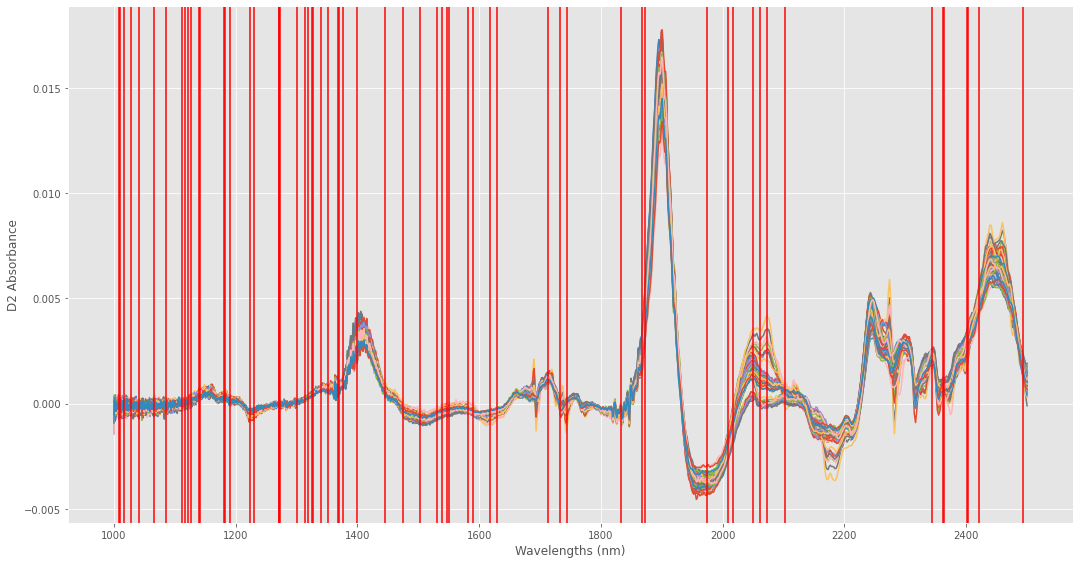

In [38]:
##Show the wavelength selected

wl = np.arange(0, 1557, 1)
print(len(wl))
wavelength_res = wl_list
plt.figure(figsize=(18, 9.5))
with plt.style.context('ggplot'):
    plt.plot(df.iloc[:,1:-2].columns.astype('float'), df_pretreat.values[:, :-3].T)
    for i in wavelength_res:
        plt.axvline(x=df.iloc[:,1:-2].columns.astype('float')[i], color='r', label='axvline - full height')
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("D2 Absorbance")
    plt.show()

1557


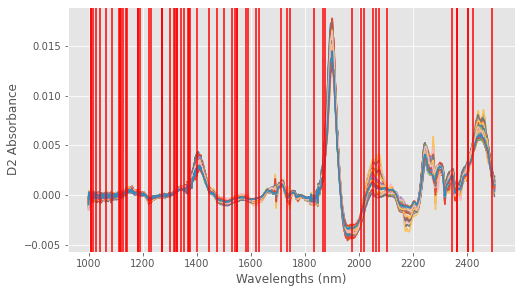

In [39]:
wl = np.arange(0, 1557, 1)
print(len(wl))
wavelength_res = wl_list
plt.figure(figsize=(8, 4.5))
with plt.style.context('ggplot'):
    plt.plot(df.iloc[:,1:-2].columns.astype('float'), df_pretreat.values[:, :-3].T)
    for i in wavelength_res:
        plt.axvline(x=df.iloc[:,1:-2].columns.astype('float')[i], color='r', label='axvline - full height')
    plt.xlabel("Wavelengths (nm)")
    plt.ylabel("D2 Absorbance")
    plt.show()